<a href="https://colab.research.google.com/github/urbanwaves10/Data-Bootcamp-Midterm-Project---Environmental-Impact-of-Citi-Bikes-JC/blob/main/Data_Bootcamp_Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saaesha Bhimjiani, Sihyun Lee

Professor Koehler

Data Bootcamp, Section 001

23 October, 2025

# Introduction

This project analyzes Jersey City’s Citi Bike data for February and September 2025 to examine how weather and seasonality influence bikeshare usage and its associated environmental benefits. Jersey City is a strong alternative for the greater New York City market while remaining manageable in data size for reproducible analysis. The dataset contains over 160,000 rides, which allows for statistically meaningful comparisons across months, rider types, and vehicle types. We have chosen February and September as both months are during the college school year, have only 1 long weekend each (President's Day and Labor Day), and are very different in their mean temperatures, which is the variable we are interested in correlating with bikeshare usage and environmental impact.

Our objectives are as follows: first, to identify how temperature and precipitation affect ridership and trip characteristics; second, to compare user behavior between members and casual riders as well as between classic and electric bike users; and third, to estimate the carbon dioxide emissions avoided when Citi Bike trips substitute for car travel. We predict that ridership increases with temperature but declines with precipitation, that member riders take longer trips, and that classic bikes and warmer months account for the majority of avoided emissions.

In [2]:
# Import required libraries
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Section 1: Data Collection & Cleaning

This section focuses on collecting and cleaning the datasets used in the analysis. We imported trip data for February and September 2025  from the Citi Bike system-data portal and daily weather data from the Open-Meteo API. After converting timestamps into datetime objects, we created calendar variables such as date, hour, and day of the week indicator to allow flexible grouping later. Trip duration is calculated as the difference between start and end times, expressed in minutes. To estimate distance, we assume an average cycling speed of 17 kilometers per hour, which appropriately represents the biking experience for dense urban areas with frequent stops. Although this introduces a simplification, it provides a consistent basis for environmental calculations.

We import weather data for February and September from the Open-Meteo API. We selected temperature, precipitation, and apparent temperature since these variables are most likely to directly influence cycling behavior. We merge trip-level data with daily weather data on the date variable.

## 1.1 Trip Data

Data Source (zip files available for download): https://citibikenyc.com/system-data

In [3]:
#Uploaded CSV file to Github to access here
feb_25_raw = 'https://raw.githubusercontent.com/urbanwaves10/Data-Bootcamp-Midterm-Project---Environmental-Impact-of-Citi-Bikes-JC/35816ee9ba9453935c3d6c6e34c0327e85c7e97c/JC-202502-citibike-tripdata%5B1%5D.csv'
feb_25_df = pd.read_csv(feb_25_raw)
sep_25_raw = 'https://raw.githubusercontent.com/urbanwaves10/Data-Bootcamp-Midterm-Project---Environmental-Impact-of-Citi-Bikes-JC/refs/heads/main/JC-202509-citibike-tripdata%5B1%5D.csv'
sep_25_df = pd.read_csv(sep_25_raw)
# NOTE: Source files are pre-cleaned by Citi Bike; schema is consistent across months.

# Combine February and September into a single trip table for easier analysis
trip_df = pd.concat([feb_25_df, sep_25_df], ignore_index=True)

#Check output
trip_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,04CF7A399050E404,classic_bike,2025-02-22 17:40:16.500,2025-02-22 17:47:22.479,Jersey & 3rd,JC074,Van Vorst Park,JC035,40.723332,-74.045953,40.718489,-74.047727,casual
1,124AC7493E82D845,classic_bike,2025-02-21 12:28:13.319,2025-02-21 12:35:44.762,Jersey & 3rd,JC074,Columbus Drive,JC014,40.723332,-74.045953,40.718355,-74.038914,member
2,1A3BCA838E968327,classic_bike,2025-02-01 14:17:43.272,2025-02-01 14:59:09.894,Jersey & 3rd,JC074,Grove St PATH,JC115,40.723332,-74.045953,40.719410,-74.043090,casual
3,5994017EE989D6EE,electric_bike,2025-02-22 11:36:29.292,2025-02-22 11:49:51.531,Jersey & 3rd,JC074,Jersey & 3rd,JC074,40.723332,-74.045953,40.723332,-74.045953,casual
4,F81BCB97915C6BE6,electric_bike,2025-02-28 22:56:26.546,2025-02-28 23:07:40.391,Jersey & 3rd,JC074,Monroe St & 11 St,HB508,40.723332,-74.045953,40.750109,-74.036637,casual


In [4]:
#Convert to datetime for easier analysis/grouping later on
trip_df['started_at'] = pd.to_datetime(trip_df['started_at'])
trip_df['ended_at'] = pd.to_datetime(trip_df['ended_at'])

#Create columns with month name, date, hour, and day of week based on starting datetime for easier navigation
trip_df['date'] = trip_df['started_at'].dt.date
trip_df['hour_of_day'] = trip_df['started_at'].dt.hour
trip_df['day_of_week'] = trip_df['started_at'].dt.day_name()
trip_df['month_name'] = trip_df['started_at'].dt.month_name()

trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161326 entries, 0 to 161325
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             161326 non-null  object        
 1   rideable_type       161326 non-null  object        
 2   started_at          161326 non-null  datetime64[ns]
 3   ended_at            161326 non-null  datetime64[ns]
 4   start_station_name  161326 non-null  object        
 5   start_station_id    161326 non-null  object        
 6   end_station_name    160859 non-null  object        
 7   end_station_id      160712 non-null  object        
 8   start_lat           161326 non-null  float64       
 9   start_lng           161326 non-null  float64       
 10  end_lat             160833 non-null  float64       
 11  end_lng             160833 non-null  float64       
 12  member_casual       161326 non-null  object        
 13  date                161326 no

In [5]:
#Get the trip duration by subtracting the starting time from the ending time. Convert the datetime timedelta output to total seconds,
# and divide the total seconds by 60 to get the difference in terms of minutes.
trip_df['trip_duration_min'] = (trip_df['ended_at'] - trip_df['started_at']).dt.total_seconds() / 60

#Estimate, in simple terms, the distance traveled by assuming average speed 17 km/hr (because of traffic). We are using the metric system because we will
# be estimating CO2 avoided later, and that is typically measured in kilograms using the metric system.
avg_speed_kmh = 17
trip_df['distance_km'] = (trip_df['trip_duration_min'] / 60) * avg_speed_kmh

#check output
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161326 entries, 0 to 161325
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             161326 non-null  object        
 1   rideable_type       161326 non-null  object        
 2   started_at          161326 non-null  datetime64[ns]
 3   ended_at            161326 non-null  datetime64[ns]
 4   start_station_name  161326 non-null  object        
 5   start_station_id    161326 non-null  object        
 6   end_station_name    160859 non-null  object        
 7   end_station_id      160712 non-null  object        
 8   start_lat           161326 non-null  float64       
 9   start_lng           161326 non-null  float64       
 10  end_lat             160833 non-null  float64       
 11  end_lng             160833 non-null  float64       
 12  member_casual       161326 non-null  object        
 13  date                161326 no

## 1.2 Weather Data

Data Source: https://open-meteo.com/en/docs

In [6]:
feb_weather_url = 'https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date=2025-02-01&end_date=2025-02-28&daily=temperature_2m_mean,precipitation_sum,apparent_temperature_mean&timezone=America%2FNew_York&temperature_unit=fahrenheit'

feb_weather_response = requests.get(feb_weather_url)

# Convert API response to JSON format
feb_weather_data = feb_weather_response.json()

# Extract the list of weather variables from the JSON structure
feb_weather = feb_weather_data['daily']

# Convert the list of weather dictionaries into a pandas DataFrame
feb_weather_df = pd.DataFrame(feb_weather)

# Preview the first few rows to confirm data structure
feb_weather_df.head()


,time,temperature_2m_mean,precipitation_sum,apparent_temperature_mean
0,2025-02-01,32.8,2.4,24.3
1,2025-02-02,23.5,1.2,15.6
2,2025-02-03,34.9,0.3,29.3
3,2025-02-04,38.1,0.3,29.9
4,2025-02-05,29.0,0.0,21.2


In [7]:
#same process as above for september weather
sep_weather_url = 'https://archive-api.open-meteo.com/v1/archive?latitude=40.7143&longitude=-74.006&start_date=2025-09-01&end_date=2025-09-30&daily=temperature_2m_mean,precipitation_sum,apparent_temperature_mean&timezone=America%2FNew_York&temperature_unit=fahrenheit'

sep_weather_response = requests.get(sep_weather_url)

# Convert API response to JSON format
sep_weather_data = sep_weather_response.json()

# Extract the list of weather variables from the JSON structure
sep_weather = sep_weather_data['daily']

# Convert the list of weather dictionaries into a pandas DataFrame
sep_weather_df = pd.DataFrame(sep_weather)

# Preview the first few rows to confirm data structure
sep_weather_df.head()

,time,temperature_2m_mean,precipitation_sum,apparent_temperature_mean
0,2025-09-01,70.4,0.0,69.1
1,2025-09-02,69.5,0.0,69.3
2,2025-09-03,68.6,0.0,69.3
3,2025-09-04,69.2,4.2,70.0
4,2025-09-05,73.7,5.1,76.8


In [8]:
#Combine the two sets of weather data
weather_df = pd.concat([feb_weather_df, sep_weather_df], ignore_index=True)

#Rename "time" column to "date" for merging with trip data later on
weather_df = weather_df.rename(columns={'time': 'date'})

#convert the "date" value to datetime for easy navigation later
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['date'] = weather_df['date'].dt.date

#check output
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       58 non-null     object 
 1   temperature_2m_mean        58 non-null     float64
 2   precipitation_sum          58 non-null     float64
 3   apparent_temperature_mean  58 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.9+ KB


## 1.3 Merge Weather Data with Trip Data & Clean

In [9]:
# Merge trip data with weather data (by date); left join preserves all trips
master_df = trip_df.merge(weather_df, on='date', how='left')

# Filter master_df to include only February and September data (for some reason, some January and August data were in the sets)
master_df = master_df[master_df['month_name'].isin(['February', 'September'])]

#see all columns
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161308 entries, 0 to 161325
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ride_id                    161308 non-null  object        
 1   rideable_type              161308 non-null  object        
 2   started_at                 161308 non-null  datetime64[ns]
 3   ended_at                   161308 non-null  datetime64[ns]
 4   start_station_name         161308 non-null  object        
 5   start_station_id           161308 non-null  object        
 6   end_station_name           160842 non-null  object        
 7   end_station_id             160695 non-null  object        
 8   start_lat                  161308 non-null  float64       
 9   start_lng                  161308 non-null  float64       
 10  end_lat                    160816 non-null  float64       
 11  end_lng                    160816 non-null  float64      

In [10]:
master_df['trip_duration_min'].describe(percentiles=[0.95, 0.995])

,trip_duration_min
count,161308.000000
mean,9.866912
std,36.842802
min,1.003933
50%,6.129725
95%,23.232730
99.5%,77.079990
max,1499.948283


The 99.5% percentile is 77 minutes, and the maximum is almost 25 hours. This maximum indicates that there are outliers that are greatly skewing the mean, so we will trim the data to include only rides that are less than or equal to 120 minutes long. This allows us to see the data from recreational rides while removing the skewing effect of extreme data points that may be caused by docking or technical issues.

The original data set has already been trimmed of rides that were under a minute, so we will not adjust the left tail of our data set.

In [11]:
#Filter out rides that were over 120 minutes long
master_df = master_df[(master_df['trip_duration_min'] <= 120)]

master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160937 entries, 0 to 161325
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ride_id                    160937 non-null  object        
 1   rideable_type              160937 non-null  object        
 2   started_at                 160937 non-null  datetime64[ns]
 3   ended_at                   160937 non-null  datetime64[ns]
 4   start_station_name         160937 non-null  object        
 5   start_station_id           160937 non-null  object        
 6   end_station_name           160541 non-null  object        
 7   end_station_id             160394 non-null  object        
 8   start_lat                  160937 non-null  float64       
 9   start_lng                  160937 non-null  float64       
 10  end_lat                    160508 non-null  float64       
 11  end_lng                    160508 non-null  float64      

# Section 2: Exploratory Data Analysis

We begin our exploratory analysis by establishing descriptive summaries of the dataset before addressing more complex relationships. First, we will summarize trip statistics and calculate baseline indicators of environmental impact, such as CO2 emissions avoided. Then, we visualize relationships among key variables, such as user and bike-type differences. Finally, we will connect ridership to external factors such as temperature and rainfall.

## 2.1 Descriptive Overview

In [12]:
print("Summary of Trip Data and Environmental Impact")
print("Total trips:", len(master_df))
print(f"% of member riders:, {round(len(master_df[master_df['member_casual'] == 'member']) / len(master_df) * 100, 2)}%") #used an f-string to get rid of space between number and % sign
print(f"% of electric bikes:, {round(len(master_df[master_df['rideable_type'] == 'electric_bike']) / len(master_df) * 100, 2)}%")
print(f"% of rides in September: {round(len(master_df[master_df['month_name'] == 'September']) / len(master_df) * 100, 2)}%")

#Summary statistics for relevant quantitative data
summary_stats = master_df[['distance_km', 'trip_duration_min']].agg(['mean', 'median', 'min', 'max', 'count']).round(2)
print(summary_stats)

Summary of Trip Data and Environmental Impact
Total trips: 160937
% of member riders:, 78.88%
% of electric bikes:, 64.21%
% of rides in September: 71.91%
        distance_km  trip_duration_min
mean           2.44               8.60
median         1.73               6.12
min            0.28               1.00
max           33.98             119.92
count     160937.00          160937.00


From this summary, we can see that riders primarily opt to bike for trips that would take more than 15 to 30 minutes to walk (it takes about 22 minutes to walk the median Citi Bike trip distance of 1.73 kilometers, or 1 mile). The distribution for trip distance and duration are both skewed right, as these variables' means are higher than their medians.

Over 60% of rides use electric bikes, while approximately 75% of rides are made by members rather than casual users. This implies a mature user base and habitual commuting behavior. However, the presence of a meaningful casual segment indicates recreational and tourist usage, especially during warmer month of September, which is when 72% of the trips in the dataset occurred. These descriptive metrics establish a clear foundation for comparing seasonal and behavioral patterns in subsequent sections.

## 2.2. Environmental Impact: CO2 Emissions Avoided

Driving Question: How much does Citi Bike usage help avoid CO2 emissions?

We estimate the avoided carbon dioxide emissions from each Citi Bike trip using a straightforward model. Each kilometer cycled replaces, with probability 0.45, an equivalent kilometer that would otherwise have been driven. This estimate is based on NYC DOT and NACTO bikeshare surveys. Based on U.S. EPA data, cars emit about 0.404 kilograms of CO₂ per mile. For electric bikes, we subtract a small adjustment (0.012 kg/km) to account for charging-related emissions. The resulting estimate provides a measure of the system’s environmental benefit.

### Calculation of CO2 Avoided

In [13]:
# Conversion assumptions
CO2_PER_MILE = 0.404            # kg of CO₂ per mile driven (EPA estimate)
MILE_PER_KM = 1 / 1.609         # km to mile conversion
CAR_SUB_RATE = 0.45             # Assume 45% of Citi Bike trips replace car trips (based on estimates from NYC DOT and NACTO bikeshare surveys)
E_BIKE_EMISSION_PER_KM = 0.012  # kg CO2/km   #because of charging emissions

# Calculate CO₂ savings per trip
master_df['CO2_avoided_kg'] = 0.0 #initialize with a float value to avoid error message

# Classic bikes (no emissions from these bikes)
mask_classic = master_df['rideable_type'] == 'classic_bike'
master_df.loc[mask_classic, 'CO2_avoided_kg'] = (master_df.loc[mask_classic, 'distance_km'] * CO2_PER_MILE * MILE_PER_KM * CAR_SUB_RATE)

# E-bikes (subtract charging emissions)
mask_electric = master_df['rideable_type'] == 'electric_bike'
master_df.loc[mask_electric, 'CO2_avoided_kg'] = (master_df.loc[mask_electric, 'distance_km'] * CO2_PER_MILE * MILE_PER_KM * CAR_SUB_RATE
                                                  - master_df.loc[mask_electric, 'distance_km'] * E_BIKE_EMISSION_PER_KM)

# Create daily summary (aggregated by date)
daily_summary_CO2 = master_df.groupby('date', as_index=False).agg(
    trips=('ride_id', 'count'),
    avg_temp=('temperature_2m_mean', 'mean'),
    rain_mm=('precipitation_sum', 'sum'),
    CO2_kg=('CO2_avoided_kg', 'sum'))
daily_summary_CO2['CO2_tons'] = daily_summary_CO2['CO2_kg'] / 1000

daily_summary_CO2.head()

,date,trips,avg_temp,rain_mm,CO2_kg,CO2_tons
0,2025-02-01,1437,32.8,3448.8,314.466397,0.314466
1,2025-02-02,1097,23.5,1316.4,263.915821,0.263916
2,2025-02-03,1795,34.9,538.5,377.812689,0.377813
3,2025-02-04,2060,38.1,618.0,431.019765,0.431020
4,2025-02-05,1986,29.0,0.0,412.868593,0.412869


In [14]:
#Summary of relevant environmental impact statistics
print("Avg CO₂ avoided (kg):", round(master_df['CO2_avoided_kg'].mean(), 3))
print("Total CO2 avoided (kg):", round(master_df['CO2_avoided_kg'].sum()))

total_CO2_avoided = daily_summary_CO2['CO2_kg'].sum()
cars_off_road = total_CO2_avoided / 4600 #4.6 metric tons emitted per car per year
print(f"\nTotal CO₂ avoided: {total_CO2_avoided/1000:.2f} metric tons")
print(f"Equivalent to removing {cars_off_road:.0f} cars off the road for that year.")

Avg CO₂ avoided (kg): 0.258
Total CO2 avoided (kg): 41511

Total CO₂ avoided: 41.51 metric tons
Equivalent to removing 9 cars off the road for that year.


Our calculations show that the average Citi Bike trip avoids roughly 0.258 kilograms of CO₂, and cumulative savings across the two months exceed 41,000 kilograms, or about the annual emissions of nine passenger vehicles. This may seem like a small contribution, but there are two considerations to make. First, these nine cars are accounted for by only 2 months of trip data. If we were to look at all the data, the annual total of yearly car usage avoided by Citi Bike trips is likely to be around 54. Additionally, Jersey City is a relatively small city with a population of 302,804 people. If we consider larger locations like New York City, the positive environmental impact would be multiplied by a factor of 25 to 30x, for a total of 1350 to 1620 cars taken off the road annually.

Source for annual car emissions: https://www.epa.gov/greenvehicles/greenhouse-gas-emissions-typical-passenger-vehicle

### Correlation Heatmap

Now that we have consolidated a daily summary of total CO2 emissions avoided by riders and understood the average emissions avoided per rider, we will be able to perform a deeper analysis on potential correlations with other variables that relate to the positive environmental impact of Citi Bikes.

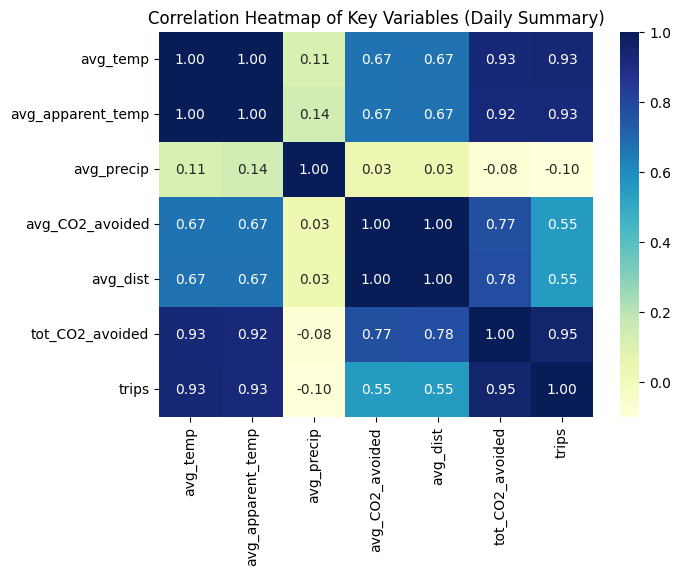

In [15]:
daily = master_df.groupby('date', as_index=False).agg(
    avg_temp=('temperature_2m_mean','mean'),
    avg_apparent_temp=('apparent_temperature_mean','mean'),
    avg_precip=('precipitation_sum','mean'),
    avg_CO2_avoided=('CO2_avoided_kg', 'mean'),
    avg_dist=('distance_km', 'mean'),
    tot_CO2_avoided=('CO2_avoided_kg', 'sum'),
    trips=('ride_id','count'))

# drop 'date' (non-numeric) to avoid errors
daily_corr = daily.drop(columns=['date'])

plt.figure(figsize=(7,5))
sns.heatmap(daily_corr.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Heatmap of Key Variables (Daily Summary)")
plt.show()

The daily-level correlation heatmap above illustrates how weather conditions correspond to changes in CO2 avoided that day and average trip distance. Warmer days are strongly associated with higher trip counts and moderately strongly associated with higher environmental benefit and longer rides, indicating that favorable weather stimulates both the number and length of rides. Daily averages of CO2 avoided per ride and daily average trip distances are perfectly correlated, which makes sense given that the CO2 avoided per ride was calculated based on trip distance length. Number of trips in a day and total CO2 avoided are strongly but not perfectly correlated, which also makes sense -- it is possible that the lack of a perfect correlation is because of outlier long trips taken on colder/rainy days.

Precipitation has the opposite effect, with a negative relationship with trip volume and total CO2 avoided, which aligns with the expectation that rain discourages cycling activity. Overall, the heatmap highlights temperature and rainfall as influential environmental variables affecting ridership.

Average and apparent temperatures are highly correlated, reflecting their shared measurement of ambient comfort. It was thought that there would be a different level of correlation between ridership and actual vs apparent mean temperature, but this matrix shows that riders don't incorporate this difference into their decision to use bikeshares.

### Monthly CO₂ Avoidance Comparison

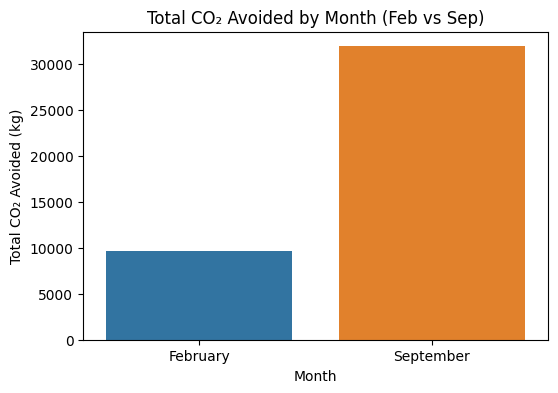

% Total CO2 avoided in September: 76.83%


In [16]:
# Group by month and sum CO₂ avoided
co2_by_month = master_df.groupby('month_name')['CO2_avoided_kg'].sum().reset_index()

# Visualize
plt.figure(figsize=(6,4))
sns.barplot(data=co2_by_month, x='month_name', y='CO2_avoided_kg', hue='month_name')
plt.title('Total CO₂ Avoided by Month (Feb vs Sep)')
plt.xlabel('Month')
plt.ylabel('Total CO₂ Avoided (kg)')
plt.show()
print(f"% Total CO2 avoided in September: {round(master_df[master_df['month_name'] == 'September']['CO2_avoided_kg'].sum() / master_df['CO2_avoided_kg'].sum() * 100, 2)}%")

This code shows that September has a much higher positive environmental impact. A deeper analysis of potential variables that motivate riders to use Citi Bikes is conducted below.

## 2.3 Analysis of Trip Data By User Type, Bike Type, and Month

Driving question: How do trip characteristics, such as distance and duration, vary across user types, bike types, and months, and what do these differences reveal about rider behavior?

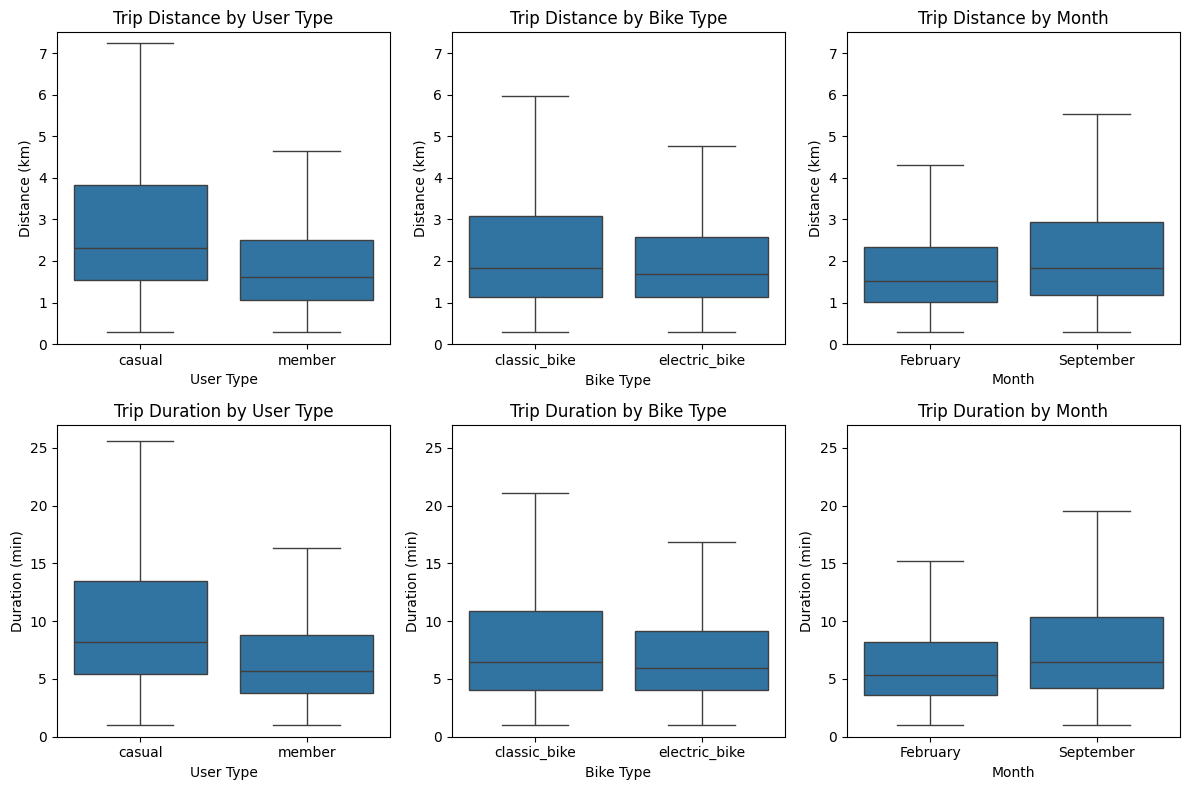

In [17]:
#Boxplots to see spread of trip distance and duration by user type, bike type, and month
boxplots, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

sns.boxplot(data=master_df, x='member_casual', y='distance_km', showfliers=False, ax=axes[0,0])
axes[0,0].set_title("Trip Distance by User Type")
axes[0,0].set_xlabel("User Type")
axes[0,0].set_ylabel("Distance (km)")
axes[0,0].set_ylim(0, 7.5)

sns.boxplot(data=master_df, x='rideable_type', y='distance_km', showfliers=False, ax=axes[0,1])
axes[0,1].set_title("Trip Distance by Bike Type")
axes[0,1].set_xlabel("Bike Type")
axes[0,1].set_ylabel("Distance (km)")
axes[0,1].set_ylim(0, 7.5)

sns.boxplot(data=master_df, x='month_name', y='distance_km', showfliers=False, ax=axes[0,2])
axes[0,2].set_title("Trip Distance by Month")
axes[0,2].set_xlabel("Month")
axes[0,2].set_ylabel("Distance (km)")
axes[0,2].set_ylim(0, 7.5)

sns.boxplot(data=master_df, x='member_casual', y='trip_duration_min', showfliers=False, ax=axes[1,0])
axes[1,0].set_title("Trip Duration by User Type")
axes[1,0].set_xlabel("User Type")
axes[1,0].set_ylabel("Duration (min)")
axes[1,0].set_ylim(0, 27)

sns.boxplot(data=master_df, x='rideable_type', y='trip_duration_min', showfliers=False, ax=axes[1,1])
axes[1,1].set_title("Trip Duration by Bike Type")
axes[1,1].set_xlabel("Bike Type")
axes[1,1].set_ylabel("Duration (min)")
axes[1,1].set_ylim(0, 27)

sns.boxplot(data=master_df, x='month_name', y='trip_duration_min', showfliers=False, ax=axes[1,2])
axes[1,2].set_title("Trip Duration by Month")
axes[1,2].set_xlabel("Month")
axes[1,2].set_ylabel("Duration (min)")
axes[1,2].set_ylim(0, 27)

boxplots.tight_layout()
boxplots.show()

The difference between the ranges/medians of casual and member users is larger than the difference between the ranges/medians of electric versus classic bikes, indicating that member type has a clearer relationship with trip duration and length than bike type.

Month and bike type have a similar relationship with trip duration and distance.

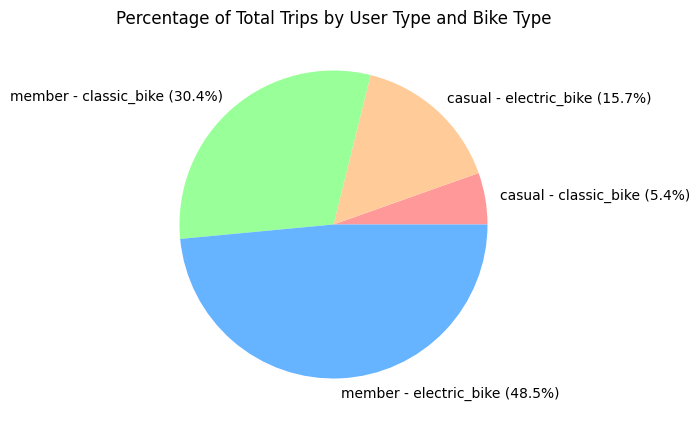

In [18]:
# Group by member_casual and rideable_type and count trips
trip_counts_by_type = master_df.groupby(['member_casual', 'rideable_type']).size().reset_index(name='trip_count')

# Calculate the percentage of total trips for each group
total_trips = len(master_df)
trip_counts_by_type['percentage'] = (trip_counts_by_type['trip_count'] / total_trips) * 100

# Create labels for the pie chart slices
trip_counts_by_type['label'] = trip_counts_by_type['member_casual'] + ' - ' + trip_counts_by_type['rideable_type'] + ' (' + trip_counts_by_type['percentage'].round(1).astype(str) + '%)'

# Create a single pie chart
plt.figure(figsize=(5, 5))
plt.pie(trip_counts_by_type['trip_count'], labels=trip_counts_by_type['label'], colors=['#ff9999','#ffcc99','#99ff99','#66b3ff']) # Using different colors for clarity
plt.title("Percentage of Total Trips by User Type and Bike Type")
plt.show()

Analyzing trip distributions by user type and bike type reveals some behavioral patterns. While members and e-bikes account for the majority of total rides, casual users and classic bikes exhibit longer median durations and distances. This likely reflects differing trip purposes: members tend to make shorter, utilitarian trips, likely for daily commute, while casual users opt for longer, but fewer, recreational rides.

These differences also help explain the larger share of avoided emissions in September, when casual usage rises and average trip duration increases. The combination of greater leisure participation and higher e-bike adoption suggests that both comfort and convenience play crucial roles in expanding bikeshare utilization.

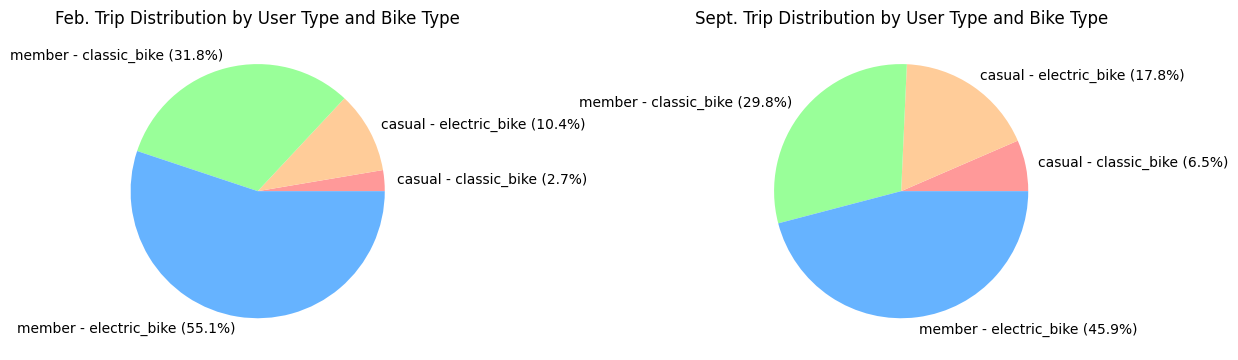

In [19]:
# Filter data for February
feb_trip_counts = master_df[master_df['month_name'] == 'February'].groupby(['member_casual', 'rideable_type']).size().reset_index(name='trip_count')
feb_total_trips = feb_trip_counts['trip_count'].sum()
feb_trip_counts['percentage'] = (feb_trip_counts['trip_count'] / feb_total_trips) * 100
feb_trip_counts['label'] = feb_trip_counts['member_casual'] + ' - ' + feb_trip_counts['rideable_type'] + ' (' + feb_trip_counts['percentage'].round(1).astype(str) + '%)'

# Filter data for September
sep_trip_counts = master_df[master_df['month_name'] == 'September'].groupby(['member_casual', 'rideable_type']).size().reset_index(name='trip_count')
sep_total_trips = sep_trip_counts['trip_count'].sum()
sep_trip_counts['percentage'] = (sep_trip_counts['trip_count'] / sep_total_trips) * 100
sep_trip_counts['label'] = sep_trip_counts['member_casual'] + ' - ' + sep_trip_counts['rideable_type'] + ' (' + sep_trip_counts['percentage'].round(1).astype(str) + '%)'

# Create a figure with two subplots (one row, two columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot pie chart for February on the first subplot
axes[0].pie(feb_trip_counts['trip_count'], labels=feb_trip_counts['label'], colors=['#ff9999','#ffcc99','#99ff99','#66b3ff'])
axes[0].set_title("Feb. Trip Distribution by User Type and Bike Type")

# Plot pie chart for September on the second subplot
axes[1].pie(sep_trip_counts['trip_count'], labels=sep_trip_counts['label'], colors=['#ff9999','#ffcc99','#99ff99','#66b3ff'])
axes[1].set_title("Sept. Trip Distribution by User Type and Bike Type")

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

Seasonal analysis shows that 78% of total avoided CO₂ originates from September trips. This outcome is driven by two factors: higher ridership volume and longer average distances in the warmer month. Pie charts comparing member and casual riders by month show that September has a higher share of casual riders and e-bike usage. This supports the idea that favorable weather stimulates occasional, leisure-oriented participation and highlights how the impact of seasonality on demand directly affects environmental outcomes.

## 2.4. Temporal Analysis

Our temporal analysis addresses the question of when, within a day or week, bikeshare usage peaks and how that varies across months.

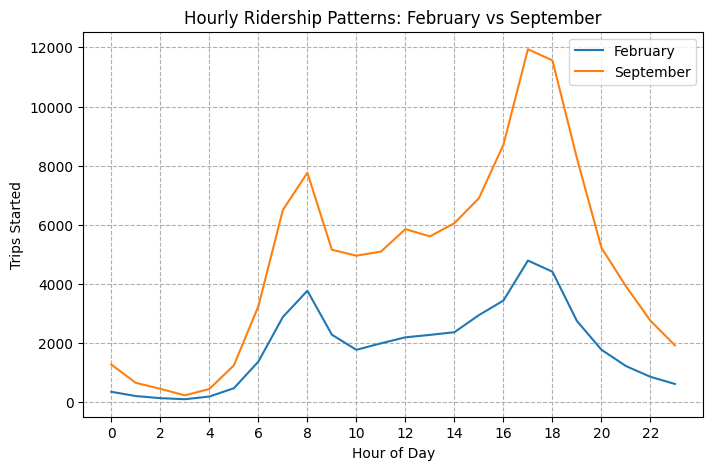

In [20]:
# Count trips per hour for each month
hourly = (master_df.groupby(['month_name','hour_of_day'])['ride_id'].count().reset_index())

# Pivot to get two lines: February, September
pivot = hourly.pivot(index='hour_of_day', columns='month_name', values='ride_id')

# Plot
plt.figure(figsize=(8,5))
plt.plot(pivot.index, pivot.get('February', pd.Series(index=pivot.index, dtype=float)), label='February')
plt.plot(pivot.index, pivot.get('September', pd.Series(index=pivot.index, dtype=float)), label='September')
plt.title('Hourly Ridership Patterns: February vs September')
plt.xlabel('Hour of Day')
plt.ylabel('Trips Started')
plt.xticks(range(0,24,2))
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

Hourly data reveal two distinct peaks on weekdays: one around 7-8 a.m. and another between 5–7 p.m., matching commuting patterns. September’s ridership curve is consistently higher, suggesting that pleasant weather amplifies both work-related and discretionary trips.

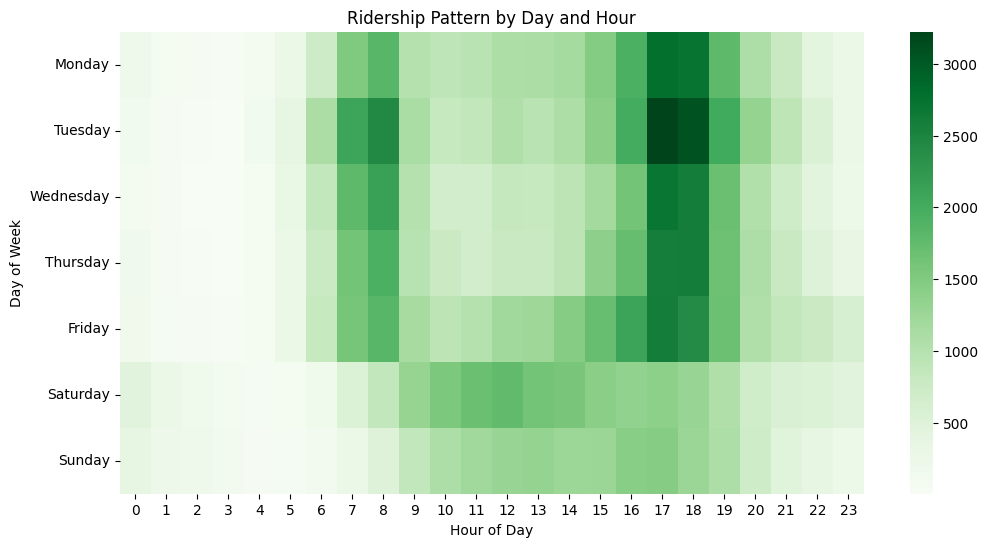

In [21]:
pivot = master_df.pivot_table(index='day_of_week', columns='hour_of_day', values='ride_id', aggfunc='count').fillna(0)
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot = pivot.reindex(weekday_order)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='Greens')
plt.title("Ridership Pattern by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

A day–hour heatmap that doesn't account for monthly differences further demonstrates these dynamics, showing weekday clustering around commute periods and broader activity spans on weekends. For operators, these insights have practical implications for bike redistribution and battery charging schedules.

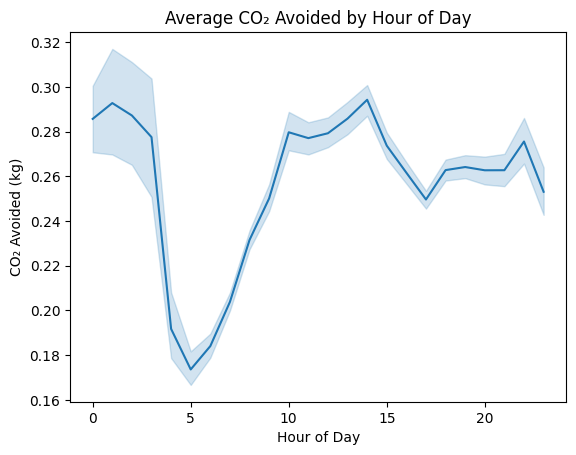

In [22]:
sns.lineplot(data=master_df, x='hour_of_day', y='CO2_avoided_kg', estimator='mean')
plt.title("Average CO₂ Avoided by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("CO₂ Avoided (kg)")
plt.show()

Average CO₂ avoided per hour increases in the morning and decreases after around 10:00 PM, with an interesting increase from 12-2:00 AM These late night rides are also seen clearly in the lineplot at the beginning of this section. It is important for operators to consider these late night rides when determining battery-charging schedules.

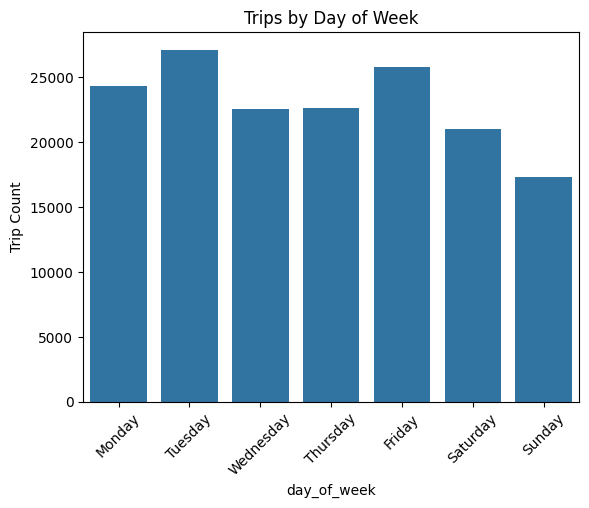

In [23]:
sns.countplot(data=master_df, x='day_of_week',
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Trips by Day of Week")
plt.ylabel("Trip Count")
plt.xticks(rotation=45)
plt.show()

This graph demonstrates that most riders use bikeshares during the weekday, suggesting that the service is primarily used for daily commute, not recreational activities.

## 2.5 Weather Correlation

How do temperature and precipitation affect ridership and trip duration, and how does weather influence the share of e-bike versus classic bike usage?

The correlation between the mean temperature and number of daily trips is: 0.93


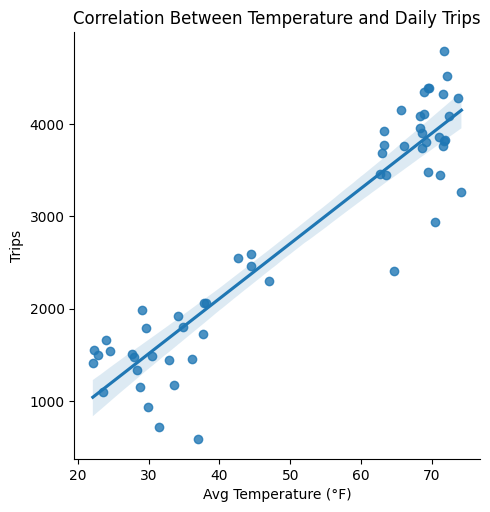

In [24]:
daily_weather = master_df.groupby('date', as_index=False).agg({
    'ride_id':'count',
    'temperature_2m_mean':'mean',
    'precipitation_sum':'mean'
})

print("The correlation between the mean temperature and number of daily trips is:",
      round(daily_weather['temperature_2m_mean'].corr(daily_weather['ride_id']), 2))

sns.lmplot(data=daily_weather, x='temperature_2m_mean', y='ride_id')
plt.title("Correlation Between Temperature and Daily Trips")
plt.xlabel("Avg Temperature (°F)")
plt.ylabel("Trips")
plt.show()

The correlation between the mean daily precipitation and number of daily trips is: -0.1


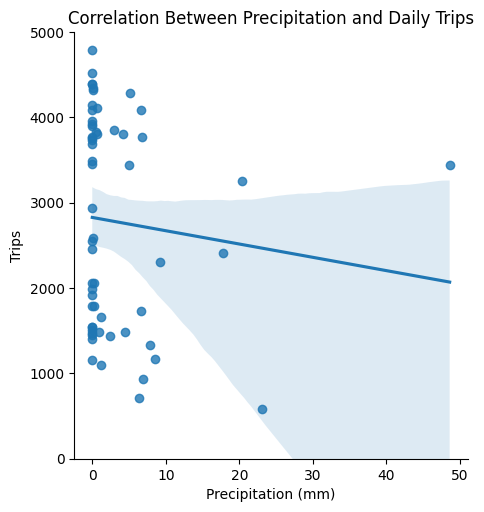

In [25]:
daily_weather = master_df.groupby('date', as_index=False).agg({
    'ride_id':'count',
    'temperature_2m_mean':'mean',
    'precipitation_sum':'mean'
})

print("The correlation between the mean daily precipitation and number of daily trips is:",
      round(daily_weather['precipitation_sum'].corr(daily_weather['ride_id']), 2))

sns.lmplot(data=daily_weather, x='precipitation_sum', y='ride_id')
plt.title("Correlation Between Precipitation and Daily Trips")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Trips")
plt.ylim(0, 5000)
plt.show()

Temperature has a much clearer and positive relationship with trip rides. Precipitation, on the other hand, has a weak negative correlation with number of daily rides.

                            OLS Regression Results                            
Dep. Variable:                ride_id   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     194.4
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           6.55e-29
Time:                        20:12:01   Log-Likelihood:                -423.02
No. Observations:                  58   AIC:                             854.0
Df Residuals:                      54   BIC:                             862.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             700.6274    

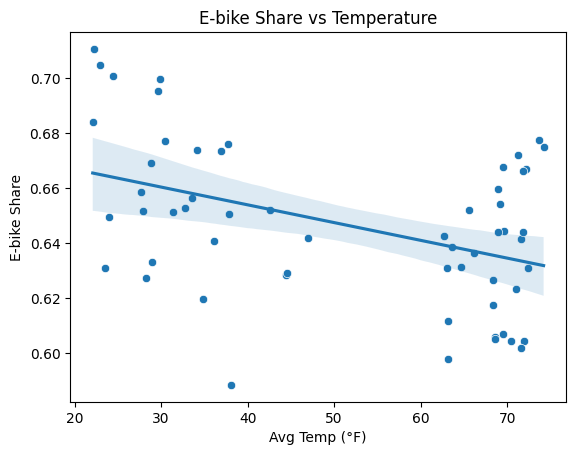

In [26]:
# 1) Non-linear trips ~ temp + temp^2 + rain
import statsmodels.formula.api as smf

daily_weather['temp2'] = daily_weather['temperature_2m_mean']**2
poly_mod = smf.ols('ride_id ~ temperature_2m_mean + temp2 + precipitation_sum', data=daily_weather).fit()
print(poly_mod.summary())

# 2) E-bike share vs temperature and rain
daily_share = (master_df
               .assign(is_ebike = (master_df['rideable_type']=='electric_bike').astype(int))
               .groupby('date').agg(ebike_share=('is_ebike','mean'),
                                    temp=('temperature_2m_mean','mean'),
                                    rain=('precipitation_sum','mean'))
               .reset_index())

share_mod = smf.ols('ebike_share ~ temp + rain', data=daily_share).fit()
print(share_mod.summary())
sns.scatterplot(data=daily_share, x='temp', y='ebike_share')
sns.regplot(data=daily_share, x='temp', y='ebike_share', scatter=False, ci=95)
plt.title("E-bike Share vs Temperature"); plt.xlabel("Avg Temp (°F)"); plt.ylabel("E-bike Share"); plt.show()


Daily trip counts plotted against temperature and rainfall demonstrate the intuitive relationship between weather and ridership. Trip volume increases sharply with temperature until roughly 80°F, after which it plateaus—a pattern confirmed by a polynomial regression including temperature squared. Rainfall exhibits a negative coefficient, indicating that even small amounts of precipitation suppress cycling activity.

The last  model exploring the share of e-bike trips shows that this share rises with temperature and falls with rain. These effects imply that warmer, dry days both increase total ridership and tilt user preference toward e-bikes, likely due to comfort and efficiency advantages.

/tmp/ipython-input-3829707064.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trips_by_temp = master_df.groupby('temp_band')['ride_id'].count().reset_index()
/tmp/ipython-input-3829707064.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trips_by_temp, x='temp_band', y='ride_id', palette='coolwarm')


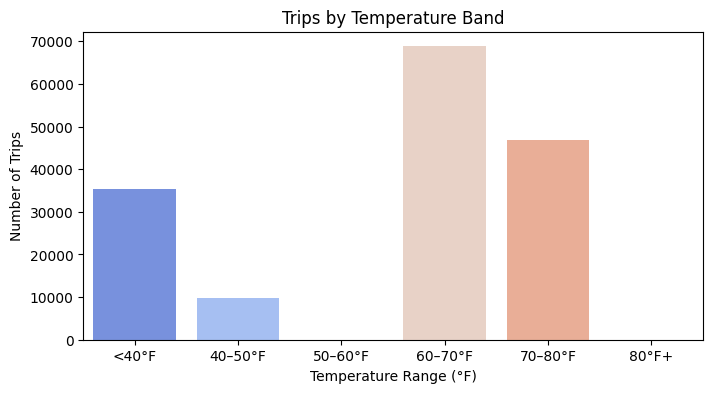

In [27]:
# Define temperature bands
master_df['temp_band'] = pd.cut(master_df['temperature_2m_mean'], bins=[0,40,50,60,70,80,100], labels=['<40°F','40–50°F','50–60°F','60–70°F','70–80°F','80°F+'])

# Count trips within each band
trips_by_temp = master_df.groupby('temp_band')['ride_id'].count().reset_index()

# Plot
plt.figure(figsize=(8,4))
sns.barplot(data=trips_by_temp, x='temp_band', y='ride_id', palette='coolwarm')
plt.title('Trips by Temperature Band')
plt.xlabel('Temperature Range (°F)')
plt.ylabel('Number of Trips')
plt.show()


When grouped into temperature bands, ridership is lowest below 40°F and peaks in the 60–80°F range, providing clear evidence of weather sensitivity and helping inform seasonal pricing or promotion strategies.

In [77]:
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

# --- Linear Regression: Temperature and Trips ---
model = smf.ols('ride_id ~ temperature_2m_mean + precipitation_sum', data=daily_weather).fit()
print(model.summary())

# --- Hypothesis Test: Trip Duration by User Type ---
member_dur = master_df[master_df['member_casual']=='member']['trip_duration_min']
casual_dur = master_df[master_df['member_casual']=='casual']['trip_duration_min']
t_stat, p_val = ttest_ind(member_dur, casual_dur, equal_var=False)
print(f"T-test result: t={t_stat:.2f}, p={p_val:.4f}")


                            OLS Regression Results                            
Dep. Variable:                ride_id   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     280.0
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           1.46e-29
Time:                        17:23:59   Log-Likelihood:                -424.57
No. Observations:                  58   AIC:                             855.1
Df Residuals:                      55   BIC:                             861.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -246.6929    

To formally assess behavioral differences, we perform a t-test comparing trip durations between members and casual users. The results reject the null hypothesis of equal means, confirming that casual riders take longer trips. This complements earlier descriptive findings and reinforces the importance of user segmentation when interpreting bikeshare demand and planning marketing or pricing strategies. Together with regression results, this test demonstrates a consistent empirical foundation for our conclusions.

## 2.6 Spatial Hotspots (Folium)

In [ ]:
import folium

#create a dataframe that summarizes the number of trips begun at each station, along with the latitudes and longitudes of those stations for mapping purposes
station_summary_df = master_df.groupby(['start_station_id', 'start_station_name', 'start_lat', 'start_lng'], as_index=False)['ride_id'].count().rename(columns={'ride_id': 'trip_count'})
station_summary_df = station_summary_df.sort_values('trip_count', ascending=False)

#use folium to create a map
trip_map = folium.Map(location=[40.72, -74.05], zoom_start=13)
for _, r in station_summary_df.iterrows():
    folium.CircleMarker(
        location=[r['start_lat'], r['start_lng']],
        radius = (r['trip_count'] / 200),  # linear scaling by trip_count to show difference between stations; adjust denominator to change visual contrast
        color='green', fill=True, fill_opacity=0.5,
        popup=f"{r['start_station_name']} — {r['trip_count']} trips"
    ).add_to(trip_map)

trip_map.save('jc_hotspots.html')
trip_map

Mapping start stations using Folium provides a spatial dimension to the analysis. High-volume origins cluster near alternative transit stations, such as PATH and train stations, waterfront paths, and areas that combine accessibility with recreational appeal. These hotspots reveal how bikeshare integrates with existing urban infrastructure, serving both as a feeder to public transit and as a standalone leisure option.

From an operational perspective, stations with the largest trip counts are ideal candidates for infrastructure reinforcement, such as expanded dock capacity or priority maintenance. Spatial concentration also explains why urban-core emissions reductions are disproportionately high: the most active stations overlap with areas that also typically experience high car traffic. In these zones, car substitution effects (such as saving time) are strongest.

# Conclusion

This analysis shows that Jersey City’s bikeshare usage is meaningfully shaped by seasonality and weather, with clear implications for both service operations and environmental benefits. Warmer, drier conditions are associated with substantially more trips and longer ride lengths, while February exhibits the same temporal structure at a lower amplitude. The hourly and day-of-week profiles reveal strong commute peaks on weekdays and broader leisure activity on weekends, indicating that Citi Bike serves both utilitarian and discretionary purposes in this market.

User and vehicle differences are central to these outcomes. Members and e-bikes account for the majority of rides, suggesting a mature, habitual user base that values reliability and speed. Still, the longer median durations among casual riders and classic bikes point to alt3ernative use cases -- specifically, recreational or exploratory rides that are more prevalent in warmer months. These compositional shifts matter, because September’s higher casual participation and greater e-bike share amplify total avoided CO2.

The environmental estimates indicate a sizable cumulative impact. Using a survey-backed substitution rate and the EPA’s emissions factor, we found that the two months in scope allow for the avoidance of roughly nine passenger vehicles’ annual emissions. Scaling to larger markets would multiply these gains substantially. The results underscore how a steady cultural shift from cars to bikes, especially during peak hours and in densely populated areas with high car traffic, can aggregate into meaningful reductions in urban transport emissions while benefitting riders' health and time-saving efforts.

From a management perspective, the evidence supports practical steps. First, staffing, rebalancing, and battery-swapping should prioritize the commute windows and the high-traffic stations identified by the map. Second, seasonal promotions aimed at casual users in colder months could smooth demand, while targeted winter interventions such as improved lighting or gear partnerships may help generate a larger share of cold-weather trips. Finally, regular reporting of avoided-emission metrics can strengthen stakeholder engagement and help signal bikeshare operations' alignment with city climate objectives.

Two limitations qualify these conclusions. Distance is inferred from duration via a conservative speed assumption, and the car-substitution rate is based on survey ranges. However, both of these limitations can be stress-tested without changing the core findings. Future work using origin–destination distances (calculated via a more complex formula such as Haversine), hourly weather, or a full-year panel would refine the estimates and allow causal identification around rain or heat shocks. Even so, the current evidence is consistent and directionally strong: in Jersey City, bikeshare demand is temperature-sensitive, temporally patterned, and environmentally consequential.